# Sources
Code adapted from: https://www.youtube.com/watch?v=q_HS4s1L8UI&t=1694s
https://courseworks2.columbia.edu/courses/198078/pages/mcm-problem-c?module_item_id=2487630
https://campus.datacamp.com/courses/intermediate-deep-learning-with-pytorch/sequences-recurrent-neural-networks?ex=7 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


df = pd.read_excel("../data/Problem_C_Data_Wordle.xlsx")

# Format the data properly
df = df.iloc[:, 1:]
df.columns = df.iloc[0]
df = df[1:]

df

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
1,2022-12-31 00:00:00,560,manly,20380,1899,0,2,17,37,29,12,2
2,2022-12-30 00:00:00,559,molar,21204,1973,0,4,21,38,26,9,1
3,2022-12-29 00:00:00,558,havoc,20001,1919,0,2,16,38,30,12,2
4,2022-12-28 00:00:00,557,impel,20160,1937,0,3,21,40,25,9,1
5,2022-12-27 00:00:00,556,condo,20879,2012,0,2,17,35,29,14,3
...,...,...,...,...,...,...,...,...,...,...,...,...
355,2022-01-11 00:00:00,206,drink,153880,3017,1,9,35,34,16,5,1
356,2022-01-10 00:00:00,205,query,107134,2242,1,4,16,30,30,17,2
357,2022-01-09 00:00:00,204,gorge,91477,1913,1,3,13,27,30,22,4
358,2022-01-08 00:00:00,203,crank,101503,1763,1,5,23,31,24,14,2


In [2]:
# Only need the contest number and the number of reported results for this model
df = df[['Contest number', 'Number of  reported results']]
df

,Contest number,Number of reported results
1,560,20380
2,559,21204
3,558,20001
4,557,20160
5,556,20879
...,...,...
355,206,153880
356,205,107134
357,204,91477
358,203,101503


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

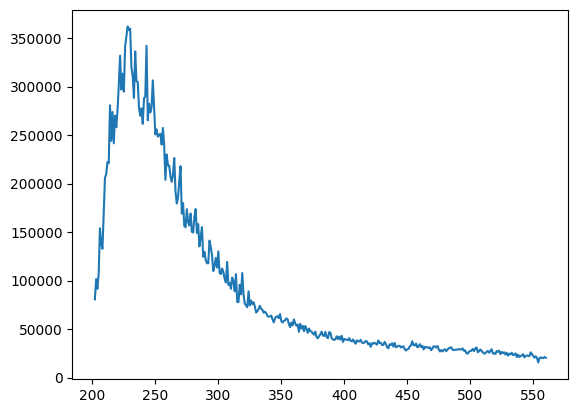

In [4]:
plt.plot(df['Contest number'], df['Number of  reported results'])

In [5]:
from copy import deepcopy as dc

# Sets up data to be passed into GRU model
def prepare_dataframe_for_model(df, n_steps):
    df = dc(df)
    df.set_index('Contest number', inplace=True)
    df = df.iloc[::-1, :]
    for i in range(1, n_steps+1):
        df[f'h(t-{i})'] = df['Number of  reported results'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_model(df, lookback)
shifted_df

,Number of reported results,h(t-1),h(t-2),h(t-3),h(t-4),h(t-5),h(t-6),h(t-7)
Contest number,,,,,,,,
209,169484,132726,137586,153880,107134,91477,101503,80630
210,205880,169484,132726,137586,153880,107134,91477,101503
211,209609,205880,169484,132726,137586,153880,107134,91477
212,222197,209609,205880,169484,132726,137586,153880,107134
213,220950,222197,209609,205880,169484,132726,137586,153880
...,...,...,...,...,...,...,...,...
556,20879,20011,15554,20281,21937,20490,22180,24137
557,20160,20879,20011,15554,20281,21937,20490,22180
558,20001,20160,20879,20011,15554,20281,21937,20490


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[169484, 132726, 137586, ..., 91477, 101503, 80630],
       [205880, 169484, 132726, ..., 107134, 91477, 101503],
       [209609, 205880, 169484, ..., 153880, 107134, 91477],
       ...,
       [20001, 20160, 20879, ..., 20281, 21937, 20490],
       [21204, 20001, 20160, ..., 15554, 20281, 21937],
       [20380, 21204, 20001, ..., 20011, 15554, 20281]], dtype=object)

In [7]:
shifted_df_as_np.shape

(352, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data to be between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.11114062, -0.32339745, -0.29533368, ..., -0.56158728,
        -0.50369275, -0.64669654],
       [ 0.09902585, -0.11114062, -0.32339745, ..., -0.47117689,
        -0.56158728, -0.52449894],
       [ 0.12055873,  0.09902585, -0.11114062, ..., -0.20124497,
        -0.47117689, -0.58319454],
       ...,
       [-0.97432107, -0.97340293, -0.96925111, ..., -0.97270423,
        -0.96314176, -0.99877644],
       [-0.96737442, -0.97432107, -0.97340293, ..., -1.        ,
        -0.97270423, -0.99030522],
       [-0.97213256, -0.96737442, -0.97432107, ..., -0.97426333,
        -1.        , -1.        ]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((352, 7), (352,))

In [10]:
# Some more formatting
X = dc(np.flip(X, axis=1))
X

array([[-0.64669654, -0.50369275, -0.56158728, ..., -0.20124497,
        -0.29533368, -0.32339745],
       [-0.52449894, -0.56158728, -0.47117689, ..., -0.29533368,
        -0.32339745, -0.11114062],
       [-0.58319454, -0.47117689, -0.20124497, ..., -0.32339745,
        -0.11114062,  0.09902585],
       ...,
       [-0.99877644, -0.96314176, -0.97270423, ..., -0.97426333,
        -0.96925111, -0.97340293],
       [-0.99030522, -0.97270423, -1.        , ..., -0.96925111,
        -0.97340293, -0.97432107],
       [-1.        , -1.        , -0.97426333, ..., -0.97340293,
        -0.97432107, -0.96737442]])

In [11]:
# Split the data into training and testing (as the original paper did)
split_index = int(len(X) * 0.8) + 1

split_index

282

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((282, 7), (70, 7), (282,), (70,))

In [13]:
# Reshape the data to be in the format that PyTorch expects
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((282, 7, 1), (70, 7, 1), (282, 1), (70, 1))

In [14]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([282, 7, 1]),
 torch.Size([70, 7, 1]),
 torch.Size([282, 1]),
 torch.Size([70, 1]))

In [15]:
from torch.utils.data import Dataset

# PyTorch dataset class for our data
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

# PyTorch dataloader for our data (to make it easier to iterate over)
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Just to help us visualize the data
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
# MODEL
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

model = GRU(1, 4, 1)
model.to(device)
model

GRU(
  (gru): GRU(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
# Hyperparameters: These weren't specified in the paper, so I just used some reasonable values
learning_rate = 0.001
num_epochs = 325
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch = 0

def train_one_epoch():
    global epoch
    model.train(True)
    epoch += 1
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [21]:
# Train the model
for i in range(num_epochs):
    train_one_epoch()

In [22]:
# Use model to predict on training data
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()


In [23]:
# Denormalize the input data back to the original scale
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([133968.7393252 , 157398.58024313, 192769.56838897, 208945.6165278 ,
       222100.19484058, 225278.40656856, 266112.73254094, 255680.10096303,
       270136.0293037 , 253799.17749551, 266904.47268608, 264452.21801856,
       274998.7545611 , 295230.3768369 , 318182.18075931, 303168.91805887,
       307750.90138352, 298688.6905241 , 322953.59624624, 335838.96763289,
       343341.02626908, 342980.86568677, 343392.10028493, 321759.50887716,
       310749.63150525, 294561.62515152, 318872.87734318, 308765.23877037,
       304232.28567517, 287119.49693894, 276094.69373298, 278707.45788848,
       269324.94544277, 283482.85772669, 289831.99374223, 321677.22066891,
       283575.63324296, 282013.70560932, 278248.34914207, 280283.7746042 ,
       298678.76061237, 285904.82719564, 262615.67981139, 259826.67520586,
       254965.89051333, 254758.59070322, 255485.46643534, 248012.35111776,
       257370.88003966, 248977.43118778, 219082.58549997, 228419.97465137,
       225499.64128599, 2

In [24]:
# Same thing for the output data
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train = y_train.flatten().to('cpu').numpy()
new_y_train

array([-0.11114062,  0.09902585,  0.12055873,  0.19324738,  0.18604665,
        0.53061897,  0.3189396 ,  0.4908042 ,  0.30464783,  0.46887287,
        0.40020904,  0.50626236,  0.6560744 ,  0.82639724,  0.6250079 ,
        0.7188541 ,  0.61183643,  0.8810812 ,  0.9408409 ,  1.        ,
        0.9784498 ,  0.9871288 ,  0.75626093,  0.7061388 ,  0.57453936,
        0.8517586 ,  0.6735363 ,  0.6704066 ,  0.52024806,  0.4686188 ,
        0.5124237 ,  0.4203214 ,  0.57227576,  0.5831606 ,  0.8850598 ,
        0.441785  ,  0.5404644 ,  0.48837316,  0.5196995 ,  0.67921835,
        0.51303   ,  0.35768607,  0.38790372,  0.34434134,  0.35617894,
        0.36011133,  0.29684082,  0.39597058,  0.29615363,  0.08661081,
        0.237699  ,  0.17244785,  0.17244785,  0.10822453,  0.07546037,
        0.11637226,  0.21722284,  0.01915959, -0.05367341, -0.01920001,
        0.08155818,  0.16818053, -0.11352547, -0.05139828, -0.18720731,
       -0.19485267, -0.08716515, -0.16497572, -0.18447022, -0.11

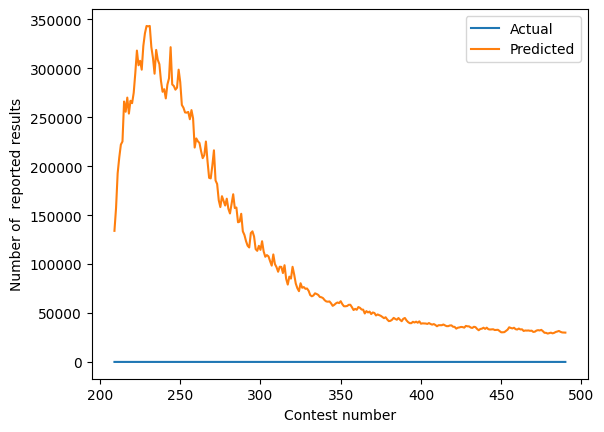

In [25]:
# Plot the results of training data
x_axis = shifted_df.index.tolist()

plt.plot(x_axis[:split_index], new_y_train, label = "Actual")
plt.plot(x_axis[:split_index], train_predictions, label='Predicted')
plt.xlabel('Contest number')
plt.ylabel('Number of  reported results')
plt.legend()
plt.show()


In [26]:
# Denormalize test split
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([30113.60405111, 30282.47448349, 30207.24662828, 30179.17037058,
       30680.49672508, 29781.39586067, 29491.6117214 , 28093.10442305,
       27212.56279075, 27629.22684169, 28290.75301957, 28682.49939179,
       29741.44912636, 29218.48753798, 30084.99104142, 31114.44006109,
       29293.94248056, 28943.91825306, 29595.22549891, 29204.16038883,
       28346.30685008, 27327.94382334, 27036.87973702, 27571.48471463,
       28256.1325165 , 27710.66863334, 28316.24873888, 29410.29379559,
       27885.36076033, 27271.23391163, 26658.90311766, 27798.71660328,
       27997.60385823, 28565.01263988, 27226.72478545, 27594.13151956,
       27234.63155508, 27449.88974559, 26495.42084944, 26873.31489158,
       25720.43355954, 26090.81307387, 25915.31581891, 26605.86789262,
       25836.84680748, 25635.95705473, 26163.83198822, 24755.08511353,
       25175.44449544, 24265.5673027 , 24181.00822067, 24561.79246581,
       25296.87431002, 24173.74142456, 24250.95113325, 24585.73986208,
      

In [27]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([29278.9960022 , 28947.00457698, 28953.0017482 , 30063.00485432,
       27608.99542069, 27905.00381857, 25155.99755812, 24672.00209945,
       26498.00138783, 27501.99597681, 27669.99934828, 29553.99881756,
       27329.9979319 , 29742.9974494 , 31068.00069219, 26096.00511712,
       27212.9963212 , 28983.99917537, 27467.00387621, 25993.00034666,
       24659.99743485, 25085.00178587, 26535.99723512, 27475.00354522,
       25575.99566466, 27465.00137842, 29208.00022995, 24748.99504292,
       24990.99793333, 24287.99734241, 27436.99737579, 26663.00101262,
       27705.00177103, 24196.99723655, 26380.99977714, 25205.99807   ,
       26051.00052756, 23739.00328273, 25568.99724454, 22627.99892771,
       24646.00059462, 23872.9951582 , 25576.99691355, 23153.0043025 ,
       23509.00505692, 24898.99657857, 21198.99998772, 23640.00350785,
       21156.99914485, 21946.99484605, 22872.99524266, 24101.00120836,
       20823.99614859, 22176.00214511, 22853.00123119, 22335.99552542,
      

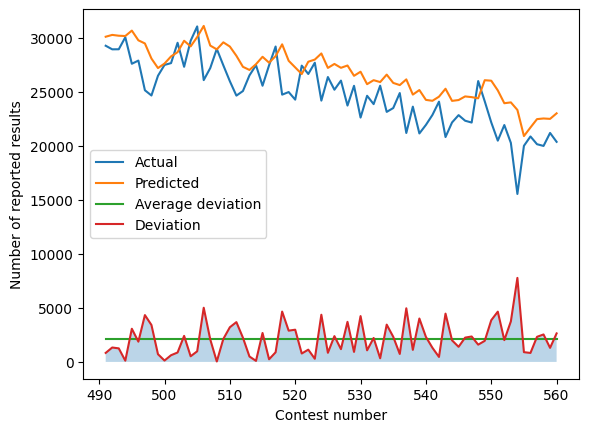

In [28]:
# Plot testing results and deviation
new_x_axis = shifted_df.index.to_list()[split_index:]

plt.plot(new_x_axis, new_y_test, label='Actual')
plt.plot(new_x_axis, test_predictions, label='Predicted')

deviation = np.abs((test_predictions - new_y_test))
average_deviation = np.mean(deviation)

plt.plot(new_x_axis, [average_deviation] * len(test_predictions), label='Average deviation')
plt.plot(new_x_axis, deviation, label='Deviation')
plt.fill_between(new_x_axis, deviation, 0, alpha=0.3)

plt.xlabel('Contest number')
plt.ylabel('Number of reported results')
plt.legend()
plt.show()


In [29]:
# Drop Christmas Day as a datapoint from both the original data and the predicted data
new_y_test_without_christmas = np.delete(new_y_test, 70 - 7)
test_predictions_without_christmas = np.delete(test_predictions, 70 - 7)

new_y_test_without_christmas.shape, test_predictions_without_christmas.shape

((69,), (69,))

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Statistical analysis of prediction data and original data
x_bar = np.mean(new_y_test_without_christmas)
x_hat_bar = np.mean(test_predictions_without_christmas)

relative_error = np.abs(x_bar - x_hat_bar)
relative_error_rate = relative_error / x_bar * 100
rmse = sqrt(mean_squared_error(new_y_test_without_christmas, test_predictions_without_christmas))
relative_rmse = rmse / x_bar * 100

print(f"Mean of original data: {x_bar}")
print(f"Mean of predicted data: {x_hat_bar}")
print(f"Relative error: {relative_error}")
print(f"Relative error rate: {relative_error_rate}")
print(f"RMSE: {rmse}")
print(f"Relative RMSE: {relative_rmse}")


Mean of original data: 24955.21716036054
Mean of predicted data: 26832.714420874916
Relative error: 1877.4972605143776
Relative error rate: 7.523465928786383
RMSE: 2470.6232360117324
Relative RMSE: 9.900227355809706


In [31]:
buffer = new_y_test_without_christmas[len(new_y_test_without_christmas) - lookback - 1:]
buffer = buffer[::-1]
buffer

array([20379.999035  , 21203.99591005, 20001.00052243, 20160.002976  ,
       20879.00290495, 20011.00268924, 20280.99926013, 21937.00300139])

In [32]:
# Predict the next 7 days
# Prepare the input data for prediction
prediction_input = shifted_df.iloc[-1:, : ].to_numpy().astype(np.float32)
# Normalize the input data
prediction_input = scaler.transform(prediction_input.reshape(1, -1)).reshape((1, lookback + 1, 1))
prediction_input = torch.tensor(prediction_input).float()
for i in range(61):
    
    # Reshape the input data to match the expected input shape of the model
    prediction_input = prediction_input.reshape((1, lookback + 1, 1))
    

    # Remove last entry of input data
    prediction_input = prediction_input[:, :-1, :]
    # Use the trained model to make predictions on the input data
    with torch.no_grad():
        prediction_output = model(prediction_input.to(device)).to('cpu').numpy().flatten()
    
    # Add prediction_output to prediction_input array
    prediction_input = np.insert(prediction_input, 0, prediction_output, axis=1)

# Denormalize the final prediction
prediction_output = prediction_output.flatten()
dummies = np.zeros((1, lookback+1))
dummies[:, 0] = prediction_output
dummies = scaler.inverse_transform(dummies)
result = dc(dummies[:, 0])
result



array([34102.80674064])

# Results
All in all, our results for this model line up really well with the paper! It's only one out of 3 models the paper used though, there are still the other objectives to tackle.